# Import Modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

# Hàm

Hàm preprocess để tiền xử lý dữ liệu, trích xuất ra:
* words: list các từ vựng của bộ dữ liệu
* num_words: số lượng từ trong bộ từ vựng words
* tags: list các tag của bộ dữ liệu
* n_tags: số lượng tag trong tags
* sentence: bộ câu kèm tag của câu đó
* word2idx: từ điển để ánh xạ từ sang index
* tag2idx: từ điển để ánh xạ tag sang index

In [2]:
def preprocess(df):
  words = []
  for i in range(len(df)):
    words += df["words"][i]

  words = list(set(words))
  words.append("ENDPAD")
  num_words = len(words)

  tags = []
  for i in range(len(df)):
    tags += df["tags"][i]

  tags = list(set(tags))
  n_tags = len(tags)

  sentence = [df.loc[i] for i in range(len(df))]

  word2idx = {w: i   for i, w in enumerate(words)}
  tag2idx = {t: i for i, t in enumerate(tags)}

  return words, num_words, tags, n_tags, sentence, word2idx, tag2idx

Hàm token_padding để tokenize các câu và tag thành index; padding câu và tag.  <br>
  **Với đầu vào:**
* padding: độ dài tối đa của câu
* sentence: bộ câu kèm tag của câu đó
* word2idx: từ điển ánh xạ từ sang index
* tag2idx: từ điển ánh xạ tag sang index
* num_words: số lượng từ trong từ điển <br><br>
  **Đầu ra:**
* X: input sequence đã được padding
* y: output sequence đã được padding

In [3]:
def token_padding(padding, sentence, word2idx, tag2idx, num_words):
  #ánh xạ từ trong câu và nhãn về index của nó
  from tensorflow.keras.preprocessing.sequence import pad_sequences
  #đặt max length cho phù hợp
  max_len = padding

  X = [[word2idx[w] for w in s[0]] for s in sentence]
  X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["ENDPAD"])

  #tương tự với nhãn
  y = [[tag2idx[w] for w in s[1]] for s in sentence]
  y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
  
  return X, y

Hàm plot_confusion_matrix để plot confustion matrix

In [4]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Hàm pred2label và test2label lần lượt dùng để chuyển index trong sequence thành tag để tiện hơn trong việc quan sát và đánh giá

In [5]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("ENDPAD", "O"))
        out.append(out_i)
    return out

# Load bộ dữ liệu NER


In [32]:
df_train = pd.read_json("/content/drive/MyDrive/Dataset/DS310_TH2/word/train_word.json", lines=True)
df_test = pd.read_json("/content/drive/MyDrive/Dataset/DS310_TH2/word/test_word.json", lines=True)
df_dev = pd.read_json("/content/drive/MyDrive/Dataset/DS310_TH2/word/dev_word.json", lines=True)

In [33]:
df = pd.concat([df_train, df_test, df_dev], axis = 0).reset_index(drop=True)

In [10]:
df["words"]

0        [Đồng_thời, ,, bệnh_viện, tiếp_tục, thực_hiện,...
1        [", Số, bệnh_viện, có_thể, tiếp_nhận, bệnh_nhâ...
2        [Ngoài_ra, ,, những, người, tiếp_xúc, gián_tiế...
3        [Bà, này, khi, trở, về, quá_cảnh, Doha, (, Qat...
4        [", Bệnh_nhân, 523, ", và, chồng, là, ", bệnh_...
                               ...                        
10022    [Sáng, 2, -, 8, ,, Bộ, Y_tế, công_bố, TP., HCM...
10023    [Tại, TP., HCM, ,, nhóm, nguy_cơ, cao, cần, đ...
10024    [Bệnh_nhân, là, bạn, (, F, 1, ), của, ", bệnh_...
10025    [Cô, chọn, các, siêu_thị, ở, xa, trung_tâm, ,,...
10026    [Sáng, nay, ,, Việt_Nam, ghi_nhận, ca, bệnh, t...
Name: words, Length: 10027, dtype: object

# Tiền xử lí

Lấy các biến cần thiết thông qua hàm preprocess

In [11]:
words, num_words, tags, n_tags, sentence, word2idx, tag2idx = preprocess(df)

In [12]:
print("Số lượng từ trong vocab: ", num_words)
print("Số lượng tag: ", n_tags)

Số lượng từ trong vocab:  8102
Số lượng tag:  20


Plot để chọn được max_len thích hợp

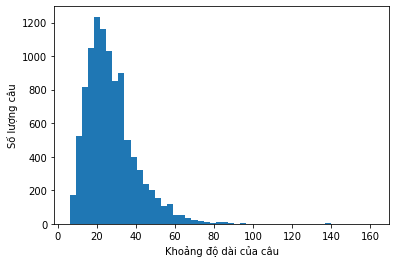

In [13]:
%matplotlib inline
plt.hist([len(sen["words"]) for sen in sentence], bins= 50)
plt.xlabel("Khoảng độ dài của câu")
plt.ylabel("Số lượng câu")
plt.show()

Ta chọn 90 là max_len

In [15]:
max_len = 90
X, y = token_padding(max_len, sentence, word2idx, tag2idx, num_words)

# Tách dữ liệu

In [16]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)

# Xây dựng Mô hình LSTM hai chiều (bi-LSTM)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

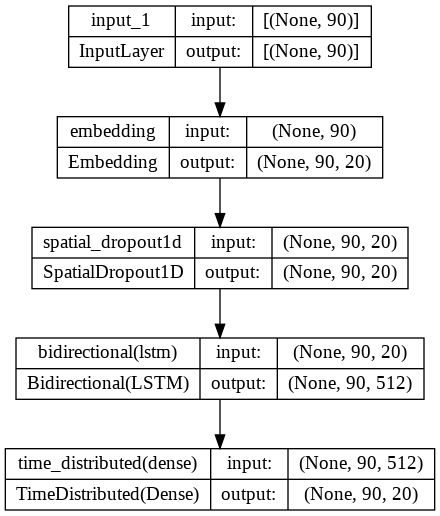

In [35]:
model = Sequential() #Yêu cầu khỏi tạo mạng LSTM 1 chiều

#Input
model.add(Input(shape=(max_len,)))
#Embedding
model.add(Embedding(input_dim = num_words, output_dim = n_tags, ))
#SpatialDropout1D
model.add(SpatialDropout1D(0.2))
#LSTM
model.add(Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.2, dropout=0.2)))
#TimeDistributed
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))
# model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

- Sử dụng trình tối ưu hoá "adam"
- sparce_categorical_crossentropy làm hàm mất mát
- Ma trận mà chúng ta sẽ quan tâm là ma trận độ chính xác.

In [36]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#Huấn luyện Model

In [37]:
# Các bạn nhớ là phải lưu mô hình khi train (có nhắc lại yêu cầu ở cuối) 
import time
start_time = time.time()

history = model.fit(
    x=x_train,
    y=y_train,
    # validation_data=(x_valid,y_valid),
    validation_split= 0.1,
    batch_size= 32, 
    epochs=2,
    verbose=1
)
print("[{}] Completed!".format(time.time() - start_time))

Epoch 1/2
226/226 [==============================] - 342s 1s/step - loss: 0.4009 - accuracy: 0.9252 - val_loss: 0.2580 - val_accuracy: 0.9307
Epoch 2/2
226/226 [==============================] - 334s 1s/step - loss: 0.1919 - accuracy: 0.9460 - val_loss: 0.1426 - val_accuracy: 0.9597
[688.8080163002014] Completed!


# Đánh giá mô hình NER



In [38]:
model.evaluate(x_test, y_test)

63/63 [==============================] - 15s 243ms/step - loss: 0.1448 - accuracy: 0.9591


[0.14479176700115204, 0.9591171145439148]

Dự đoán

In [39]:
idx2tag = {i: w for w, i in tag2idx.items()}

test_pred = model.predict(np.array(x_test))

pred_labels = pred2label(test_pred)
test_labels = test2label(y_test)

63/63 [==============================] - 16s 242ms/step


Tính confusion matrix bằng cách cộng dồn confusion matrix của từng mẫu

In [42]:
sorted_tags = sorted(tags,key=lambda name: (name[1:], name[0]))
cfs_matrix = np.zeros((len(sorted_tags), len(sorted_tags)))
from sklearn.metrics import confusion_matrix
for i in range(len(test_labels)):
  cfs_matrix = np.add(confusion_matrix(np.array(test_labels)[i], np.array(pred_labels)[i], labels = sorted_tags), cfs_matrix)

Tính toán metric từ confusion matrix

In [43]:
import math
cols_cfs_matrix = cfs_matrix.T
sum_cfs_matrix = np.sum(cfs_matrix)
f1_scores = 0

for i in range(len(sorted_tags)):
  true_positive = cfs_matrix[i][i]
  false_positive = np.sum(cols_cfs_matrix[i]) - true_positive
  false_negative = np.sum(cfs_matrix[i]) - true_positive
  true_negative = sum_cfs_matrix - true_positive - false_negative - false_positive
  precision = true_positive / (true_positive + false_positive)
  recall = true_positive / (true_positive + false_negative)  
  f1 = 2 * (precision * recall) / (precision + recall)
  if(math.isnan(f1)):
    f1 = 0
  f1_scores += f1
  print(sorted_tags[i])
  print("     True Positive = {}, False Positive = {} , True Negative = {}, False Negative = {}".format(true_positive, false_positive, true_negative, false_negative))
  print("     Precision: {}, Recall: {}, F1-score: {}".format(precision, recall, f1))
  print("")
print("F1-macro: {}".format(f1_scores / len(sorted_tags)))

O
     True Positive = 167113.0, False Positive = 3404.0 , True Negative = 9297.0, False Negative = 726.0
     Precision: 0.9800371810435323, Recall: 0.9956744260869047, F1-score: 0.9877939211954273

B-AGE
     True Positive = 0.0, False Positive = 0.0 , True Negative = 180225.0, False Negative = 315.0
     Precision: nan, Recall: 0.0, F1-score: 0

I-AGE
     True Positive = 0.0, False Positive = 0.0 , True Negative = 180539.0, False Negative = 1.0
     Precision: nan, Recall: 0.0, F1-score: 0

B-DATE
     True Positive = 258.0, False Positive = 83.0 , True Negative = 179371.0, False Negative = 828.0
     Precision: 0.7565982404692082, Recall: 0.23756906077348067, F1-score: 0.36159775753328666

I-DATE
     True Positive = 768.0, False Positive = 419.0 , True Negative = 179121.0, False Negative = 232.0
     Precision: 0.6470092670598147, Recall: 0.768, F1-score: 0.7023319615912209

B-GENDER
     True Positive = 0.0, False Positive = 0.0 , True Negative = 180277.0, False Negative = 263.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Plot Confusion Matrix

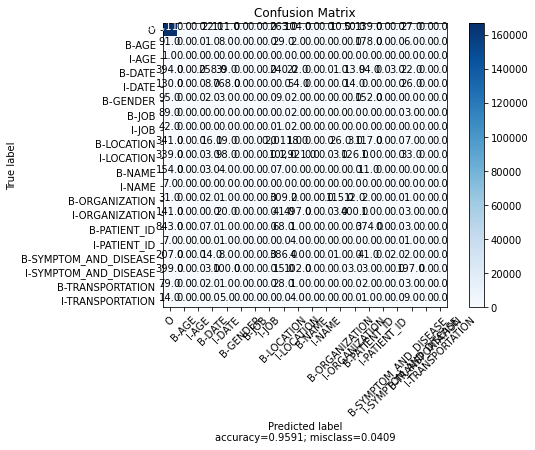

In [44]:
plot_confusion_matrix(cm           = cfs_matrix,
                      normalize    = False,
                      target_names = sorted_tags,
                      title        = "Confusion Matrix")

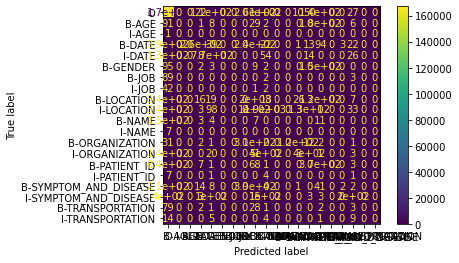

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cfs_matrix, display_labels=sorted_tags)
disp.plot()
plt.show()

# Lưu model

Các bạn lưu lại model đã lưu và bộ trong số model

In [49]:
import pickle
# model.save("/content/drive/MyDrive/Dataset/DS310_TH2/model_bai2.h5")
model.save_weights("/content/drive/MyDrive/Dataset/DS310_TH2/weight_bai2.h5")

pickle.dump(model, open('/content/drive/MyDrive/Dataset/DS310_TH2/model_bai2.pkl', 'wb'))

In [47]:
# import keras
# model = keras.models.load_model('/content/drive/MyDrive/Dataset/DS310_TH2/model_bai2.h5') 
# model.load_weights("/content/drive/MyDrive/Dataset/DS310_TH2/weight_bai2.h5")
pickled_model = pickle.load(open('/content/drive/MyDrive/Dataset/DS310_TH2/model_bai2.pkl', 'rb'))

In [48]:
pickled_model.evaluate(x_test, y_test)

63/63 [==============================] - 21s 333ms/step - loss: 0.1448 - accuracy: 0.9591


[0.14479176700115204, 0.9591171145439148]